In [1]:
from qulacs import *
from qulacsvis import circuit_drawer
from openfermion.ops.operators.qubit_operator import QubitOperator
from qulacs import Observable
from qulacs.observable import create_observable_from_openfermion_text
from qulacs.gate import *

#from qutip import *
#from qutip.qip.circuit import QubitCircuit, Gate
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm

### Hamiltonian using OpenFermion

In [43]:
# Target Hamiltonian
from typing import List
from openfermion.ops.operators.qubit_operator import QubitOperator
from qulacs import Observable
from qulacs.observable import create_observable_from_openfermion_text


def create_ising_hamiltonian(nqubits: int, cn: float, bn: float) -> Observable:
    """ "
    Args:
        nqubits: int, number of qubits
        cn: `List`, 0.0 - 1.0, coupling constant
        bn: `List`, 0.0 - 1.0, magnetic field

    Returns:
        qulacs observable
    """
    hami = QubitOperator()
    for i in range(nqubits - 1):
        hami += cn * QubitOperator(f"Z{i} Z{i+1}") * (1/4)
    for j in range(nqubits):
        hami += bn * QubitOperator(f"X{j}")


    #simple_hami = create_observable_from_openfermion_text(str(QubitOperator("Z1")))

    return create_observable_from_openfermion_text(str(hami))

In [55]:
# Construct the target Hamiltonian
cn = 1.0
bn = 1.0
r = 0
nqubits = 3
hamiltonian = create_ising_hamiltonian(nqubits= nqubits, cn= cn, bn= bn)
print(hamiltonian.get_matrix().toarray())

[[ 0.5+0.j  1. +0.j  1. +0.j  0. +0.j  1. +0.j  0. +0.j  0. +0.j  0. +0.j]
 [ 1. +0.j  0. +0.j  0. +0.j  1. +0.j  0. +0.j  1. +0.j  0. +0.j  0. +0.j]
 [ 1. +0.j  0. +0.j -0.5+0.j  1. +0.j  0. +0.j  0. +0.j  1. +0.j  0. +0.j]
 [ 0. +0.j  1. +0.j  1. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j  1. +0.j]
 [ 1. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j  1. +0.j  1. +0.j  0. +0.j]
 [ 0. +0.j  1. +0.j  0. +0.j  0. +0.j  1. +0.j -0.5+0.j  0. +0.j  1. +0.j]
 [ 0. +0.j  0. +0.j  1. +0.j  0. +0.j  1. +0.j  0. +0.j  0. +0.j  1. +0.j]
 [ 0. +0.j  0. +0.j  0. +0.j  1. +0.j  0. +0.j  1. +0.j  1. +0.j  0.5+0.j]]


#### 👀 Exact eigen values of the Hamiltonian

In [45]:
eigenvalues, _ = np.linalg.eigh(hamiltonian.get_matrix().toarray())
print(eigenvalues)
print(f"Ground state: {min(eigenvalues)}")

[-3.03124812 -1.36815091 -1.         -0.66309722  0.66309722  1.
  1.36815091  3.03124812]
Ground state: -3.0312481223319576


### Time evolution gate

In [46]:
def create_time_evolution(hamiltonian: Observable, t: float)->QuantumGateMatrix:
    nqubits = hamiltonian.get_qubit_count()
    hamiltonian_matrix = hamiltonian.get_matrix().toarray()
    time_evolution = expm(-1j * hamiltonian_matrix * t)
    time_evolution_gate = DenseMatrix([i for i in range(1, nqubits+1)], time_evolution)
    return time_evolution_gate

### Pauli X and Y observable

In [47]:
Pauli_X = QubitOperator()
Pauli_Y = QubitOperator()
Pauli_X = create_observable_from_openfermion_text(str(QubitOperator("X0")))
Pauli_Y = create_observable_from_openfermion_text(str(QubitOperator("Y0")))

### Initial tensor product state

In [48]:
from qulacs import QuantumState
from qulacs.state import inner_product, tensor_product

ancilla_state = QuantumState(1)
ancilla_state.set_zero_state()
sys_state = QuantumState(nqubits)
#sys_state.set_Haar_sys_state()

initial_state = tensor_product(ancilla_state, sys_state)
print(initial_state.get_vector())

[1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]


### Hadamard test to compute trace

In [60]:
from qulacs.state import partial_trace

def run_h_test(nqubits: int, 
               unitary: QuantumGateMatrix, 
               initial_state: QuantumState, 
               ) -> List:
    """
    Args:
        nqubit: number of qubits
        unitary: exp(-iHt)
        initial_state: initil tensor product state of ancilla and system
        ancilla_state: final state of ancilla qubit after tracting out system from initial tensor state
        
    Returns:
        a list
    """
    x_cont, y_cont = [], []
    circuit = QuantumCircuit(nqubits + 1)
    # Control unitary
    control_index = 0
    control_with_value = 1
    unitary.add_control_qubit(control_index, control_with_value)
    circuit.add_H_gate(0)
    circuit.add_gate(unitary, 1)
    
    circuit.update_quantum_state(initial_state)

    ancilla_state = partial_trace(initial_state, list(range(1, nqubits + 1)))
    
    for _ in range(1000):
        tempX = Pauli_X.get_expectation_value(ancilla_state) # type: ignore
        x_cont.append(tempX)
        tempY = Pauli_Y.get_expectation_value(ancilla_state) # type: ignore
        y_cont.append(tempY)
    X_val = np.mean(x_cont)
    Y_val = np.mean(y_cont)
    print(f"Test: X = {X_val}, Y = {Y_val}")
    return([X_val, Y_val, circuit])

#### ✔ Quantum circuit

Test: X = 0.11214370181870457, Y = 0.15081943522081348


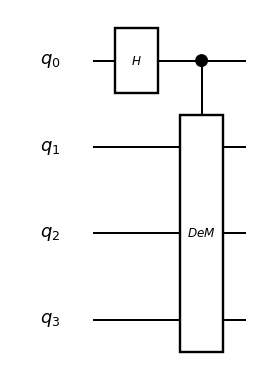

In [61]:
circuit_test = run_h_test(nqubits, create_time_evolution(hamiltonian= hamiltonian, t= 1), initial_state)[2]
circuit_drawer(circuit_test,"mpl")

In [62]:
def evaluate_sum(lb: int, 
                 ub: int, 
                 a: float, 
                 E: float,
                 ) -> complex:
    sum = 0
    del_t = 0.5
    for i in range(lb, ub):
        t = i * del_t
        U_gate = create_time_evolution(hamiltonian= hamiltonian, t= t)
        trace = run_h_test(nqubits= nqubits, unitary= U_gate, initial_state= initial_state)
        sum += np.sqrt(a/np.pi) * np.exp(-a * t * t) * np.exp(1j * E * t) * ( trace[0] + (1j * trace[1]) ) * del_t
       
    return sum

Test: X = -0.16598594558544694, Y = -0.24132286674286132
Test: X = 0.1424719023198853, Y = 0.10441993747099354
Test: X = 0.4000392616446141, Y = -0.4829056590368334
Test: X = 0.024296620913588328, Y = -0.1380239148095368
Test: X = -0.006909795006879826, Y = 0.28915913463343806
Test: X = 0.02429662091358836, Y = -0.28915913463343806
Test: X = 0.400039261644614, Y = 0.13802391480953657
Test: X = 0.1424719023198851, Y = 0.48290565903683275
Test: X = -0.1659859455854467, Y = -0.10441993747099369
Test: X = 0.11214370181871082, Y = 0.24132286674286132
Test: X = -0.17316306078455682, Y = 0.05396183677427079
Test: X = -0.01521862326721024, Y = 0.17153744278744418
Test: X = -0.08406274063616827, Y = 0.63608061985426
Test: X = 0.309161015573796, Y = -0.32799703331093905
Test: X = -0.0879662254732822, Y = 0.41918362798677666
Test: X = 0.309161015573796, Y = -0.41918362798677655
Test: X = -0.08406274063616832, Y = 0.32799703331093905
Test: X = -0.015218623267210183, Y = -0.6360806198542598
Test: X

C:\Users\das_a\AppData\Local\Temp\ipykernel_13740\3336956857.py:31: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='upper right')


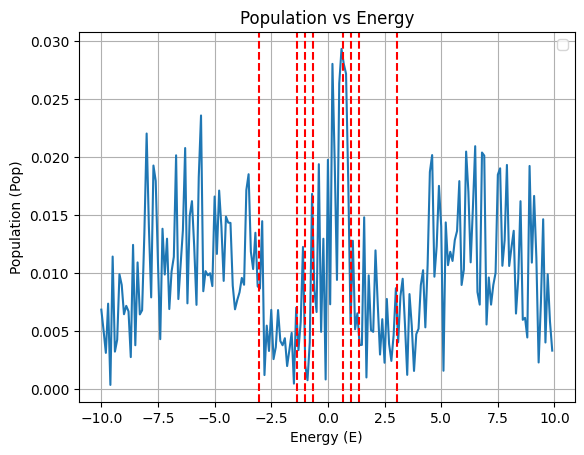

In [64]:
# Parameters
a = 0.001
lb = -5
ub = 5

pop = []
E_values = np.arange(-10, 10, 0.1)

for E in E_values:

    I = evaluate_sum(lb, ub, a, E)
    #print(I)
    #pop.append(abs(I))
    pop.append(abs(I))

# Plotting
plt.plot(E_values, pop)
plt.xlabel('Energy (E)')
plt.ylabel('Population (Pop)')
plt.title('Population vs Energy')
plt.grid(True)

# Exact values for vertical lines
#exact_values = [-2.23606798, -2.23606798, -1.0, -1.0, 1.0, 1.0, 2.23606798, 2.23606798]

# Plot vertical lines for exact values
for value in eigenvalues:
    plt.axvline(x=value, color='red', linestyle='--')

# Optionally, add a legend to avoid duplicate entries for the same line
plt.legend(loc='upper right')

plt.show()